In [4]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [5]:
import sklearn.datasets
wine = sklearn.datasets.load_wine()
wine.data.shape

(178, 13)

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    wine.data[:, :2], 
    wine.target, 
    test_size=0.3, 
    shuffle=True)

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)

# y_train consist of numbers of wines (0,1 or 2) 
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

In [19]:
class WineNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(WineNet, self).__init__()
        
        self.fc1 = torch.nn.Linear(2, n_hidden_neurons)
        self.activ1 = torch.nn.Sigmoid()
        # self.fc2 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons)
        # self.activ2 = torch.nn.Sigmoid()
        self.fc3 = torch.nn.Linear(n_hidden_neurons, 3)
        self.sm = torch.nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.activ1(x)
        # x = self.fc2(x)
        # x = self.activ2(x)
        x = self.fc3(x)
        return x

    def inference(self, x):
        x = self.forward(x)
        x = self.sm(x)
        return x
    
wine_net = WineNet(5)

In [20]:
loss = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(wine_net.parameters(), 
                             lr=1.0e-3)

In [21]:
np.random.permutation(5)

array([0, 3, 4, 2, 1])

In [22]:
print(X_train.shape)
print(y_train)

torch.Size([124, 2])
tensor([2, 0, 0, 2, 1, 2, 0, 0, 0, 0, 1, 0, 0, 2, 2, 1, 2, 0, 2, 2, 0, 1, 1, 2,
        0, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 0, 0, 2, 0, 0, 1, 0, 1, 2, 1, 1, 2,
        1, 2, 0, 0, 0, 0, 2, 0, 2, 2, 2, 1, 1, 1, 0, 1, 2, 0, 1, 1, 2, 0, 2, 2,
        0, 1, 0, 1, 1, 1, 1, 0, 2, 1, 0, 1, 0, 1, 1, 1, 1, 2, 1, 0, 1, 1, 0, 1,
        0, 1, 1, 0, 2, 0, 0, 1, 0, 1, 0, 0, 2, 1, 0, 2, 1, 0, 0, 1, 0, 2, 0, 2,
        2, 0, 1, 1])


In [23]:
batch_size = 10
n_epochs = 5000
learning_progress = []

for epoch in range(n_epochs):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        x_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]
        
        preds = wine_net.forward(x_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()
        
    if epoch % 100 == 0:
        test_preds = wine_net.forward(X_test)
        test_preds = test_preds.argmax(dim=1)
        learning_progress.append((test_preds == y_test).float().mean())
        print(learning_progress[-1])

tensor(0.2963)
tensor(0.5741)
tensor(0.6481)
tensor(0.7222)
tensor(0.7593)
tensor(0.7963)
tensor(0.7778)
tensor(0.7963)
tensor(0.7963)
tensor(0.7778)
tensor(0.8148)
tensor(0.7778)
tensor(0.8148)
tensor(0.8148)
tensor(0.8148)
tensor(0.7963)
tensor(0.7963)
tensor(0.8148)
tensor(0.7963)
tensor(0.7963)
tensor(0.7963)
tensor(0.8148)
tensor(0.8148)
tensor(0.8148)
tensor(0.8148)
tensor(0.7963)
tensor(0.8519)
tensor(0.7963)
tensor(0.8333)
tensor(0.8148)
tensor(0.8148)
tensor(0.8148)
tensor(0.8148)
tensor(0.8333)
tensor(0.8333)
tensor(0.8333)
tensor(0.8333)
tensor(0.8333)
tensor(0.8333)
tensor(0.8333)
tensor(0.8333)
tensor(0.8333)
tensor(0.8333)
tensor(0.8333)
tensor(0.8148)
tensor(0.8333)
tensor(0.8333)
tensor(0.8148)
tensor(0.8333)
tensor(0.8333)


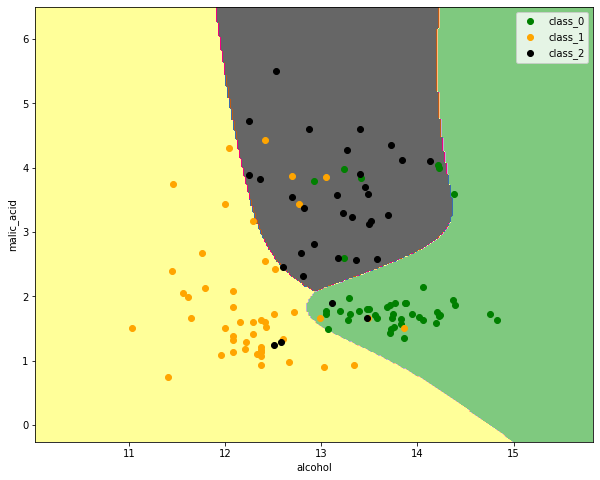

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (10, 8)

n_classes = 3
plot_colors = ['g', 'orange', 'black']
plot_step = 0.02

x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1

xx, yy =  torch.meshgrid(torch.arange(x_min, x_max, plot_step),
                         torch.arange(y_min, y_max, plot_step))

preds = wine_net.inference(
    torch.cat([xx.reshape(-1, 1), yy.reshape(-1, 1)], dim=1))

preds_class = preds.data.numpy().argmax(axis=1)
preds_class = preds_class.reshape(xx.shape)
plt.contourf(xx, yy, preds_class, cmap='Accent')

for i, color in zip(range(n_classes), plot_colors):
    indexes = np.where(y_train == i)
    plt.scatter(X_train[indexes, 0], 
                X_train[indexes, 1], 
                c=color, 
                label=wine.target_names[i],
                cmap='Accent')
    plt.xlabel(wine.feature_names[0])
    plt.ylabel(wine.feature_names[1])
    plt.legend()

# Try to expereiment

In [69]:
from sklearn.model_selection import train_test_split

# Use all 13 input bariables
X_train, X_test, y_train, y_test = train_test_split(
    wine.data[:, :], 
    wine.target, 
    test_size=0.3, 
    shuffle=True)

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)

# y_train consist of numbers of wines (0,1 or 2) 
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

In [70]:
X_train.shape

torch.Size([124, 13])

In [88]:
class WineNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(WineNet, self).__init__()
        
        self.fc1 = torch.nn.Linear(13, n_hidden_neurons)
        self.activ1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons)
        self.activ2 = torch.nn.Sigmoid()
        self.fc3 = torch.nn.Linear(n_hidden_neurons, 3)
        self.sm = torch.nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.activ1(x)
        x = self.fc2(x)
        x = self.activ2(x)
        x = self.fc3(x)
        return x

    def inference(self, x):
        x = self.forward(x)
        x = self.sm(x)
        return x
    
wine_net = WineNet(5)

In [89]:
loss = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(wine_net.parameters(), 
                             lr=1.0e-2)

In [90]:
batch_size = 10
n_epochs = 5000
learning_progress = []

for epoch in range(n_epochs):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        x_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]
        
        preds = wine_net.forward(x_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()
        
    if epoch % 100 == 0:
        test_preds = wine_net.forward(X_test)
        test_preds = test_preds.argmax(dim=1)
        learning_progress.append((test_preds == y_test).float().mean())
        print(learning_progress[-1])

tensor(0.3889)
tensor(0.3889)
tensor(0.3889)
tensor(0.3889)
tensor(0.3889)
tensor(0.3889)
tensor(0.3889)
tensor(0.3889)
tensor(0.3889)
tensor(0.3889)
tensor(0.3889)
tensor(0.3889)
tensor(0.3889)
tensor(0.3889)
tensor(0.3889)
tensor(0.3889)
tensor(0.3889)
tensor(0.3889)
tensor(0.3889)
tensor(0.3889)
tensor(0.3889)
tensor(0.3889)
tensor(0.3889)
tensor(0.3889)
tensor(0.3889)
tensor(0.3889)
tensor(0.3889)
tensor(0.3889)
tensor(0.3889)
tensor(0.3889)
tensor(0.3889)
tensor(0.3889)
tensor(0.3889)
tensor(0.3889)
tensor(0.3889)
tensor(0.3889)
tensor(0.3889)
tensor(0.3889)
tensor(0.3889)
tensor(0.3889)
tensor(0.3889)
tensor(0.3889)
tensor(0.3889)
tensor(0.3889)
tensor(0.3889)
tensor(0.3889)
tensor(0.3889)
tensor(0.3889)
tensor(0.3889)
tensor(0.3889)


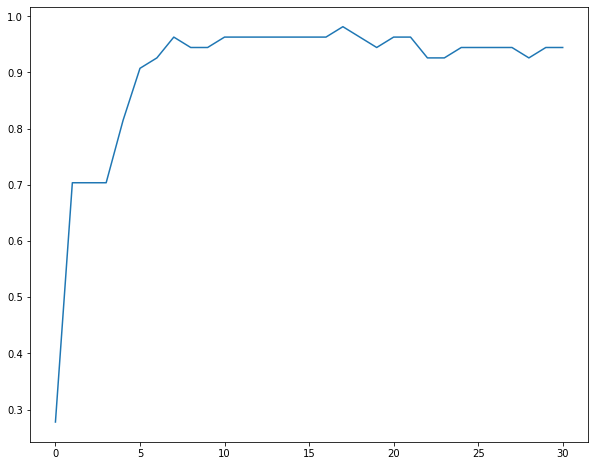

In [74]:
plt.plot(learning_progress)

plt.show()

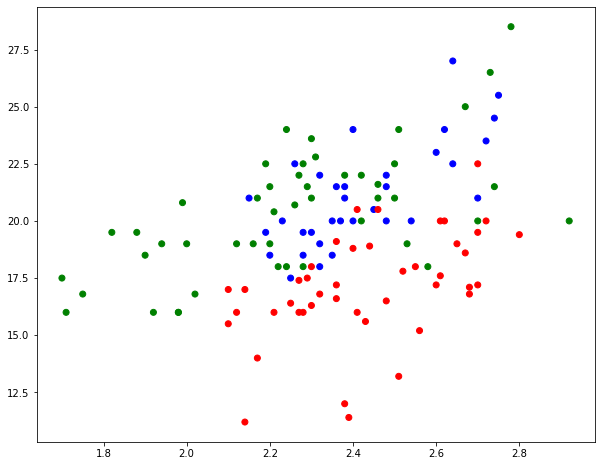

In [61]:
colors = ['r', 'g', 'b']
# colors = viridis(np.linspace(0,12,))
y_train_color = [ colors[a] for a in y_train ]

fig,ax = plt.subplots()
# ax.scatter(X_train[:,0], X_train[:,1], color=cm.get_cmap('Spectral', 8)(0.56))
ax.scatter(X_train[:,2], X_train[:,3], color=y_train_color)

In [56]:
import seaborn as sns
from  matplotlib import colors
from matplotlib import cm

sns.color_palette("hls", 8)

[(0.86, 0.3712, 0.33999999999999997),
 (0.86, 0.7612000000000001, 0.33999999999999997),
 (0.5688000000000001, 0.86, 0.33999999999999997),
 (0.33999999999999997, 0.86, 0.5012000000000001),
 (0.33999999999999997, 0.8287999999999999, 0.86),
 (0.33999999999999997, 0.43879999999999986, 0.86),
 (0.6311999999999998, 0.33999999999999997, 0.86),
 (0.86, 0.33999999999999997, 0.6987999999999996)]

In [76]:
test_preds = wine_net.inference(X_test)

print(test_preds.max(axis=1))

torch.return_types.max(
values=tensor([0.9992, 0.9944, 0.9988, 0.6656, 0.9993, 0.9984, 0.9961, 0.9934, 0.6380,
        0.9987, 0.9993, 0.8429, 0.9977, 0.9961, 0.9966, 0.9993, 0.9867, 0.9986,
        0.9991, 0.9918, 0.9987, 0.9477, 0.9987, 0.9961, 0.9993, 0.9993, 0.9938,
        0.9984, 0.9932, 0.9979, 0.9879, 0.9987, 0.9927, 0.9987, 0.9947, 0.9966,
        0.9993, 0.9956, 0.9987, 0.9987, 0.9961, 0.9987, 0.9987, 0.9985, 0.9993,
        0.9870, 0.9987, 0.9987, 0.9987, 0.9987, 0.8959, 0.9961, 0.9961, 0.8492],
       grad_fn=<MaxBackward0>),
indices=tensor([1, 2, 1, 1, 1, 1, 2, 2, 0, 0, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 0, 0, 0, 1,
        1, 1, 0, 1, 2, 1, 2, 0, 2, 0, 2, 0, 1, 2, 0, 0, 2, 0, 0, 1, 1, 1, 0, 0,
        0, 0, 0, 2, 2, 2]))
